In [154]:
import pandas as pd

# patent_data_path = 'E:\\dataset\\全球AI专利数据\\'
patent_data_path = '/Users/zongchang/Desktop/work/学校技术资料/数据集/全球AI专利数据/raw'

df = pd.read_excel(patent_data_path+'/1.xls')


In [155]:
header_map = {'标题':'title', '摘要':'abstract', '申请人':'applicants', '公开（公告）号':'public_id', 
              '公开（公告）日':'public_date', '申请号':'apply_id', '申请日':'apply_date', '专利类型':'patent_type',
              '公开国别':'public_country', '标题（翻译）':'title_trans', '标题（小语种原文）':'title_small_lang', 
              '摘要（翻译）':'abstract_trans', '摘要（小语种原文）':'abstract_small_lang', '首项权利要求':'claims',
              '权利要求数量':'claim_num', '文献页数':'page_num', '首权字数':'claim_char_num', '技术功效句':'tech_perform',
              '技术功效短语':'tech_perform_short', 'IPC主分类':'main_ipc', 'IPC':'ipc', '国民经济分类':'eco_class',
              '申请人(翻译)':'applicant_trans', '申请人(其他)':'applicant_other', '标准化申请人':'applicant_standard',
              '标准化当前权利人':'obligee_standard', '当前权利人':'obligee', '第一申请人':'applicant_first',
              '申请人数量':'applicant_num', '申请人类型':'applicant_type', '申请人国别代码':'applicant_country',
              '申请人地址':'applicant_addr', '申请人地址(其他)':'applicant_addr_other', '第一发明人':'inventor_first',
              '发明人':'inventors', '发明人数量':'inventor_num', '发明人国别':'inventor_country', '发明人地址':'inventor_addr',
              '引证专利':'references', '被引证专利':'citations', '家族引证':'family_references', '家族被引证': 'family_citations',
              '引证申请人':'ref_applicants', '被引证申请人':'cite_applicants', '引证次数':'ref_num', '被引证次数':'cite_num',
              '被引证国别(forward)':'cite_countries', '简单同族':'family_simple', '扩展同族':'family_extend', 
              '专利有效性':'availability', '当前法律状态':'legal_status_now', '法律状态':'legal_status', 
              '转让次数':'transfer_num', '转让执行日':'transfer_date', '转让人':'transfer_person', '受让人':'accept_person',
              '首次公开日':'public_date_first', '授权公告日':'authorize_date', '实质审查生效日':'check_date', '国民经济分类':'NEC', 'CPC':'cpc'
             }

In [156]:
df = df[list(header_map.keys())]
df.rename(columns=header_map, inplace=True)

In [157]:
df = df.fillna('')
df.head(10).to_dict(orient='records')

[{'title': '一种基于采矿过程的矿石三维坐标获取方法及其装置',
  'abstract': '本发明公开了一种基于采矿过程的矿石三维坐标获取方法及其装置，获取矿石图片；采用YOLACT算法和NMS算法对矿石图片进行处理得出预测掩码图；根据预测掩码图绘制矩形框，并通过矩形框得出矿石的二维坐标；获取彩色图和红外深度图；将彩色图传入至预训练模型中进行识别获得物体的轮廓；选取目标物体的轮廓，计算轮廓上所有点的X轴和Y轴的坐标之和，再将坐标之和除以轮廓上点的个数，得出目标物体的重心；计算目标物体的重心和原点的距离得出极坐标，并通过仿射变换进行对齐，得出彩色图在红外深度图中的缩放比例；将极坐标的长度乘以缩放比例，得到彩色图中的点所对应红外深度图中的点，从而深度信息；结合二维坐标和深度信息，得出矿石的三维坐标。',
  'applicants': '五邑大学',
  'public_id': 'CN110706267A',
  'public_date': Timestamp('2020-01-17 00:00:00'),
  'apply_id': 'CN201910831631.0',
  'apply_date': Timestamp('2019-09-04 00:00:00'),
  'patent_type': '发明申请',
  'public_country': 'CN',
  'title_trans': 'Ore three-dimensional coordinate obtaining method and device based on mining process',
  'title_small_lang': '',
  'abstract_trans': 'The invention discloses an ore three-dimensional coordinate collection method and device based on a mining process. The method comprises the following steps :  acquiring an ore picture;  processing the ore picture by adopting a YOLACT algorithm 

## 专利引证网络构建（输出原始数据集） 

In [158]:
# 三元组：
# citedBy: (patentId: patentId)
# relatedTo: (patentId: cpc)
# appliedBy: (patentId: applicant)
# locatedIn: (patentId: country)
# 公开日：
# {publicDate: patentId}
# 标题：
# {patentId: title}

In [160]:
file_num = 127
citation_triples = {}
cpc_triples = {}
pubdate_dict = {}
applicant_triples = {}
inventor_triples = {}
country_triples = {}
title_dict = {}
abstract_dict = {}

for i in range(file_num):
    df = pd.read_excel(patent_data_path+'/'+str(i+1)+'.xls')
    df = df[list(header_map.keys())]
    df.rename(columns=header_map, inplace=True)
    df = df.fillna('')
    tmp = df.to_dict(orient='records')
    for item in tmp:
        # process citation relations
        if item['citations']:
            cite_list = item['citations'].split('; ')
            citation_triples[item['public_id']] = cite_list
        # process cpc relations
        if item['cpc']:
            cpc_list = item['cpc'].split('; ')
            cpc_triples[item['public_id']] = cpc_list
        # process public dates
        public_date = item['public_date'].strftime("%Y-%m-%d")
        if public_date in pubdate_dict:
            pubdate_dict[public_date].append(item['public_id'])
        else:
            pubdate_dict[public_date] = [item['public_id']]
        # process applicants
        if item['applicants']:
            applicant_list = item['applicants'].split('; ')
            applicant_triples[item['public_id']] = applicant_list
        # process inventors
        if item['inventors']:
            inventor_list = item['inventors'].split('; ')
            inventor_triples[item['public_id']] = inventor_list
        # process public country
        if item['public_country']:
            country_triples[item['public_id']] = item['public_country']
        # process title
        if item['title_trans'] and item['public_country']=='CN':
            title_dict[item['public_id']] = item['title_trans']
        if item['title'] and item['public_country']!='CN':
            title_dict[item['public_id']] = item['title']
        # process abstract
        if item['abstract_trans'] and item['public_country']=='CN':
            abstract_dict[item['public_id']] = item['abstract_trans']
        if item['abstract'] and item['public_country']!='CN':
            abstract_dict[item['public_id']] = item['abstract']
        
    print('processed file' + str(i+1))

processed file1
processed file2
processed file3
processed file4
processed file5
processed file6
processed file7
processed file8
processed file9
processed file10
processed file11
processed file12
processed file13
processed file14
processed file15
processed file16
processed file17
processed file18
processed file19
processed file20
processed file21
processed file22
processed file23
processed file24
processed file25
processed file26
processed file27
processed file28
processed file29
processed file30
processed file31
processed file32
processed file33
processed file34
processed file35
processed file36
processed file37
processed file38
processed file39
processed file40
processed file41
processed file42
processed file43
processed file44
processed file45
processed file46
processed file47
processed file48
processed file49
processed file50
processed file51
processed file52
processed file53
processed file54
processed file55
processed file56
processed file57
processed file58
processed file59
proces

In [161]:
citation_triples[list(citation_triples.keys())[19]]

['CN111489597A', 'CN111260974A']

In [162]:
cpc_triples[list(citation_triples.keys())[9]]

['G01C21/3638', 'G06T19/006']

In [163]:
applicant_triples[list(citation_triples.keys())[19]]

['郑州财经学院']

In [164]:
inventor_triples[list(citation_triples.keys())[19]]

['闫静']

In [165]:
country_triples[list(citation_triples.keys())[19]]

'CN'

In [166]:
title_dict[list(citation_triples.keys())[19]]

'Intelligent English teaching system'

In [167]:
abstract_dict[list(citation_triples.keys())[19]]

'The invention provides an intelligent English teaching system. The system comprises a sound sensor,  a signal processing circuit,  an input control device,  an image acquisition module,  an image processing module,  a central processing device,  a standard pronunciation database,  a characteristic quantity extraction module,  a display,  a trigger module,  a display device,  a comparison module and a storagedevice. Image information of students in class is acquired through the image acquisition module. An image processing module is used for sharpening collected images,  the sound sensor is used for collecting pronunciation signals of students,  the signal processing circuit is used for amplifying and filtering the pronunciation signals,  and the characteristic quantity of the processed pronunciation signals is compared with the characteristic quantity of standard pronunciation so as to judge the pronunciation accuracy of the students.'

In [168]:
# 按年动态三元组序列
# {year：{relatedTo: [(pantentId, CPC),...], {citedBy: [(patentId, patentId), ...]}
import pickle
from datetime import datetime

years = ['2002', '2003','2004','2005','2006','2007','2008','2009','2010','2011','2012','2013','2014','2015','2016','2017','2018','2019','2020','2021']
# years = ['2002']
patents_title = {}
for year in years:
    res = {'relatedTo': [], 'citedBy': [], 'appliedBy': [], 'locatedIn': []}
    
    all_patent_before_dict = {}
    for pubdate in pubdate_dict.keys():
        if datetime.strptime(pubdate,'%Y-%m-%d') <= datetime.strptime(year+'-12-31','%Y-%m-%d'):
            for item in pubdate_dict[pubdate]:
                all_patent_before_dict[item] = 0
    all_patent_before_year = list(all_patent_before_dict.keys())
    print(len(all_patent_before_year))
    
    count = 0
    for patent in all_patent_before_dict.keys():
        if patent in cpc_triples:
            for item in cpc_triples[patent]:
                res['relatedTo'].append((patent, item))
        if patent in citation_triples:
            for item in citation_triples[patent]:
                if item in all_patent_before_dict:
                    res['citedBy'].append((patent, item))
        if patent in applicant_triples:
            for item in applicant_triples[patent]:
                res['appliedBy'].append((patent, item))
        if patent in country_triples:
            res['locatedIn'].append((patent, country_triples[patent]))
            
        if patent not in patents_title:
            if patent in title_dict:
                patents_title[patent] = title_dict[patent]
        
        count += 1
        if count % 1000 == 0:
            print(count)
                    
    with open(patent_data_path+'/'+year+'_patent_graph', 'wb') as f:
        pickle.dump(res, f)
    print('processed year ' + year)

with open(patent_data_path+'/patent_title', 'wb') as f:
    pickle.dump(patents_title, f)
print('processed patent attribute')


9707
1000
2000
3000
4000
5000
6000
7000
8000
9000
processed year 2002
20283
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
processed year 2003
32136
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
processed year 2004
44760
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
processed year 2005
59413
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000


153000
154000
155000
156000
157000
158000
159000
160000
161000
162000
163000
164000
165000
166000
167000
168000
169000
170000
171000
172000
173000
174000
175000
176000
177000
178000
179000
180000
181000
182000
183000
184000
185000
186000
187000
188000
189000
190000
191000
192000
193000
194000
195000
196000
197000
198000
199000
200000
201000
202000
203000
204000
205000
206000
207000
208000
209000
210000
211000
212000
213000
214000
215000
216000
217000
218000
219000
220000
221000
222000
223000
224000
225000
226000
227000
228000
229000
230000
231000
232000
233000
234000
235000
236000
237000
238000
239000
240000
241000
242000
243000
244000
245000
246000
247000
248000
249000
250000
251000
252000
253000
254000
255000
256000
processed year 2014
309451
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43

423000
424000
425000
426000
427000
428000
429000
430000
431000
432000
433000
434000
435000
436000
437000
438000
439000
440000
441000
442000
443000
444000
445000
446000
447000
448000
449000
450000
451000
452000
453000
454000
455000
456000
457000
458000
459000
460000
461000
462000
463000
464000
465000
466000
467000
468000
469000
470000
471000
472000
473000
474000
475000
processed year 2017
603754
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102

561000
562000
563000
564000
565000
566000
567000
568000
569000
570000
571000
572000
573000
574000
575000
576000
577000
578000
579000
580000
581000
582000
583000
584000
585000
586000
587000
588000
589000
590000
591000
592000
593000
594000
595000
596000
597000
598000
599000
600000
601000
602000
603000
604000
605000
606000
607000
608000
609000
610000
611000
612000
613000
614000
615000
616000
617000
618000
619000
620000
621000
622000
623000
624000
625000
626000
627000
628000
629000
630000
631000
632000
633000
634000
635000
636000
637000
638000
639000
640000
641000
642000
643000
644000
645000
646000
647000
648000
649000
650000
651000
652000
653000
654000
655000
656000
657000
658000
659000
660000
661000
662000
663000
664000
665000
666000
667000
668000
669000
670000
671000
672000
673000
674000
675000
676000
677000
678000
679000
680000
681000
682000
683000
684000
685000
686000
687000
688000
689000
690000
691000
692000
693000
694000
695000
696000
697000
698000
699000
700000
701000
702000
703000

974000
975000
976000
977000
978000
979000
980000
processed year 2020
1178452
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000
108000
109000
110000
111000
112000
113000
114000
115000
116000
117000
118000
119000
120000
121000
122000
123000
124000
125000
126000
127000
128000
129000
130000
131000
132000
133000
134000
135000
136000
137000
138000
139000
140000
141000
142000
143000
144000
145000
146000
147000
14

1157000
1158000
1159000
1160000
1161000
1162000
1163000
1164000
1165000
1166000
1167000
1168000
1169000
1170000
1171000
1172000
1173000
1174000
1175000
1176000
1177000
1178000
processed year 2021
processed patent attribute


In [169]:
len(list(patents_title.keys()))

1177558

In [170]:
year = '2021'
with open(patent_data_path+'/'+year+'_patent_graph', 'rb') as f:
    tmp = pickle.load(f)
tmp

{'relatedTo': [('CN110706267A', 'G06T2207/10024'),
  ('CN110706267A', 'G06T2207/10048'),
  ('CN110706267A', 'G06T2207/20081'),
  ('CN110706267A', 'G06T7/50'),
  ('CN110706267A', 'G06T7/66'),
  ('CN110706267A', 'E21C39/00'),
  ('CN110706267A', 'E21C41/22'),
  ('CN110706267A', 'G06K9/00208'),
  ('CN110706267A', 'G06K9/3233'),
  ('CN110706267A', 'G06K9/4604'),
  ('CN110706267A', 'G06K9/4652'),
  ('CN110706267A', 'G06K9/6257'),
  ('CN110706267A', 'G06K2209/21'),
  ('CN110706267A', 'G01V8/02'),
  ('CN110706267A', 'G06K9/2018'),
  ('CN110706268A', 'G06T19/006'),
  ('CN110706268A', 'G06T7/70'),
  ('CN110706268A', 'G06T7/50'),
  ('CN110706269A', 'G06T2207/10016'),
  ('CN110706269A', 'G06T2207/10024'),
  ('CN110706269A', 'G06T2207/10028'),
  ('CN110706269A', 'G06T7/215'),
  ('CN110706269A', 'G06T7/285'),
  ('CN110706269A', 'G06T7/55'),
  ('CN110706270A', 'G06T2207/10012'),
  ('CN110706270A', 'G06T2207/20081'),
  ('CN110706270A', 'G06T2207/20084'),
  ('CN110706270A', 'G06T7/593'),
  ('CN11070627

In [171]:
item_dict = {}
for item in tmp['locatedIn']:
    if item[1] not in item_dict:
        item_dict[item[1]] = 0
    else:
        continue

In [172]:
len(list(item_dict.keys()))

72

## 专利网络的进一步处理（适用到模型中）

In [49]:
import networkx as nx
import numpy as np
import collections

patent_data_path = '/Users/zongchang/Desktop/work/学校技术资料/数据集/全球AI专利数据/raw'
years = ['2012','2013','2014','2015','2016','2017','2018','2019','2020','2021']
for year in years:
    with open(patent_data_path+'/'+year+'_patent_graph', 'rb') as f:
        tmp = pickle.load(f)
        nodes = []
        for pair in tmp['locatedIn']:
            nodes.append(pair[0])
            nodes.append(pair[1])
        nodes = list(set(nodes))
        print(len(nodes))

181503
214736
256944
309520
378852
475442
603826
772219
980661
1178524


In [173]:
import networkx as nx
import numpy as np
import collections

patent_dataset_path = '/Users/zongchang/OneDrive/可泛化知识计算引擎/experiments/data/AIPatent'
years = ['2002', '2003','2004','2005','2006','2007','2008','2009','2010','2011','2012','2013','2014','2015','2016','2017','2018','2019','2020','2021']
# years = ['2015','2016','2017','2018','2019','2020','2021']
# years = ['2002']
for year in years:
    patent = {}
    cpc = {}
    applicant = {}
    country = {}
    index_name = {}
    name_index = {}
    res = {}
    with open(patent_data_path+'/'+year+'_patent_graph', 'rb') as f:
        tmp = pickle.load(f)
        # dictionary of index and names
        for pair in tmp['citedBy']:
            if pair[0] not in patent:
                patent[pair[0]] = 0
            if pair[1] not in patent:
                patent[pair[1]] = 0
        for pair in tmp['relatedTo']:
            if pair[0] not in patent:
                patent[pair[0]] = 0
            if pair[1] not in cpc:
                cpc[pair[1]] = 0
        for pair in tmp['appliedBy']:
            if pair[0] not in patent:
                patent[pair[0]] = 0
            if pair[1] not in applicant:
                applicant[pair[1]] = 0
        for pair in tmp['locatedIn']:
            if pair[0] not in patent:
                patent[pair[0]] = 0
            if pair[1] not in country:
                country[pair[1]] = 0
        index = 0
        for item in patent.keys():
            name_index[item] = index
            index += 1
        for item in cpc:
            name_index[item] = index
            index += 1
        for item in applicant:
            name_index[item] = index
            index += 1
        for item in country:
            name_index[item] = index
            index += 1
        index_name = {value:key for key, value in name_index.items()}
        res['idx_name'] = index_name
        res['name_idx'] = name_index
        print('completed index and name dictionary of '+ year)
        
        # graph generation according to relation type
        cite_list = [(name_index[item[0]], name_index[item[1]]) for item in tmp['citedBy']]
        relate_list = [(name_index[item[0]], name_index[item[1]]) for item in tmp['relatedTo']]
        apply_list = [(name_index[item[0]], name_index[item[1]]) for item in tmp['appliedBy']]
        locate_list = [(name_index[item[0]], name_index[item[1]]) for item in tmp['locatedIn']]
        G_cite = nx.Graph()
        G_cite.add_nodes_from(list(index_name.keys()))
        G_cite.add_edges_from(cite_list)
        G_relate = nx.Graph()
        G_relate.add_nodes_from(list(index_name.keys()))
        G_relate.add_edges_from(relate_list)
        G_apply = nx.Graph()
        G_apply.add_nodes_from(list(index_name.keys()))
        G_apply.add_edges_from(apply_list)
        G_locate = nx.Graph()
        G_locate.add_nodes_from(list(index_name.keys()))
        G_locate.add_edges_from(locate_list)
        res['adj'] = {'citedBy': G_cite, 'relatedTo': G_relate, 'appliedBy': G_apply, 'locatedIn': G_locate}
        print('completed graphs for relations of '+ year)
        
        # node features - random with range according to node type
        feature_dict = {}
        for item in patent.keys():
            feature_dict[name_index[item]] = np.random.uniform(0, 1, 10)
        for item in cpc.keys():
            feature_dict[name_index[item]] = np.random.uniform(-1, 0, 10)
        for item in applicant.keys():
            feature_dict[name_index[item]] = np.random.uniform(1, 2, 10)
        for item in country.keys():
            feature_dict[name_index[item]] = np.random.uniform(-2, -1, 10)
        feature_dict_order = collections.OrderedDict(sorted(feature_dict.items()))
        features = np.array(list(feature_dict_order.values()))
        res['feature'] = features
        print('completed node feature initialization of '+ year)
    
    with open(patent_dataset_path+'/patent_graph_'+year, 'wb') as f:
        pickle.dump(res, f)
    print('processed year ' + year)


completed index and name dictionary of 2002
completed graphs for relations of 2002
completed node feature initialization of 2002
processed year 2002
completed index and name dictionary of 2003
completed graphs for relations of 2003
completed node feature initialization of 2003
processed year 2003
completed index and name dictionary of 2004
completed graphs for relations of 2004
completed node feature initialization of 2004
processed year 2004
completed index and name dictionary of 2005
completed graphs for relations of 2005
completed node feature initialization of 2005
processed year 2005
completed index and name dictionary of 2006
completed graphs for relations of 2006
completed node feature initialization of 2006
processed year 2006
completed index and name dictionary of 2007
completed graphs for relations of 2007
completed node feature initialization of 2007
processed year 2007
completed index and name dictionary of 2008
completed graphs for relations of 2008
completed node feature 

In [174]:
tmp = None
with open(patent_dataset_path+'/patent_graph_2021', 'rb') as f:
    tmp = pickle.load(f)

In [175]:
nx.number_of_nodes(tmp['adj']['citedBy'])

1533481

In [176]:
len(list(tmp['name_idx'].keys()))

1533481

In [46]:
# 引用量结果数据构建，每年每篇patent后连续10年的引用量
# years = ['2002', '2003','2004','2005','2006','2007','2008','2009','2010','2011']
years = ['2012','2013','2014','2015','2016','2017','2018','2019','2020','2021']
def citation_labels_10_years(years):
    patent_dataset_path = '/Users/zongchang/OneDrive/可泛化知识计算引擎/experiments/data/AIPatent'
    patent_citation_seq = {}
    with open(patent_dataset_path+'/temporal_graph_'+years[0], 'rb') as f:
        tmp = pickle.load(f)
    for item in list(tmp['name_idx'].keys()):
        patent_citation_seq[item] = [{years[0]: tmp['adj']['citedBy'].degree(tmp['name_idx'][item])}]
    for year in years[1:]:
        with open(patent_dataset_path+'/temporal_graph_'+year, 'rb') as f:
            tmp = pickle.load(f)
            patents = list(tmp['name_idx'].keys())
            for item in patents:
                if item in patent_citation_seq:
                    patent_citation_seq[item].append({year: tmp['adj']['citedBy'].degree(tmp['name_idx'][item])})
                else:
                    continue
    patent_citation_seq_non_zero = {}
    flag = False
    for name, cite in patent_citation_seq.items():
        for item in cite:
            for k, v in item.items():
                if v != 0:
                    flag = True
                else:
                    continue
        if flag:
            patent_citation_seq_non_zero[name] = cite
        flag = False
    with open(patent_dataset_path+'/citation_label_10_'+years[0], 'wb') as f:
        pickle.dump(patent_citation_seq_non_zero, f)

# citation_labels_10_years(years)

In [47]:
years = ['2002', '2003','2004','2005','2006','2007','2008','2009','2010','2011','2012','2013','2014','2015','2016','2017','2018','2019','2020','2021']

citation_labels_10_years(years)

In [21]:
import pickle
year = 9
patent_dataset_path = '/Users/zongchang/OneDrive/可泛化知识计算引擎/experiments/data/AIPatent'
patent_citation_seq = {}
with open(patent_dataset_path+'/citation_label_10_2012', 'rb') as f:
    tmp = pickle.load(f)
for k,v in tmp.items():
    patent_citation_seq[k] = v[:year]
with open(patent_dataset_path+'/citation_label_'+str(year)+'_2012', 'wb') as f:
    pickle.dump(patent_citation_seq, f)


In [3]:
import pickle
patent_dataset_path = '/Users/zongchang/OneDrive/可泛化知识计算引擎/experiments/data/AIPatent'
with open(patent_dataset_path+'/citation_label_10_2012', 'rb') as f:
    tmp = pickle.load(f)
len(tmp.keys())

103333

In [4]:
# sample randomly from all patents in 2012
import random
patent_names = list(tmp.keys())
sample_index = random.sample(range(len(patent_names)), 10000)
sample_names = [patent_names[i] for i in sample_index]
with open(patent_dataset_path+'/sample_names_2012', 'a') as f:
    for name in sample_names:
          f.write(name + '\n')

In [252]:
patent_dataset_path = '/Users/zongchang/OneDrive/可泛化知识计算引擎/experiments/data/AIPatent'
with open(patent_dataset_path+'/sample_names_2012', 'r') as f:
    content = f.readlines()
    tmp = [name.strip() for name in content]
len(tmp)

10000

In [254]:
import pickle
patent_dataset_path = '/Users/zongchang/OneDrive/可泛化知识计算引擎/experiments/data/AIPatent'
with open(patent_dataset_path+'/temporal_graph_2012', 'rb') as f:
    graph_2012 = pickle.load(f)
with open(patent_dataset_path+'/temporal_graph_2011', 'rb') as f:
    graph_2011 = pickle.load(f)

In [48]:
# 引用量趋势展现
import pickle
patent_dataset_path = '/Users/zongchang/OneDrive/可泛化知识计算引擎/experiments/data/AIPatent'
with open(patent_dataset_path+'/citation_label_10_2002', 'rb') as f:
    tmp = pickle.load(f)

In [147]:
import numpy as np
tmp_squeeze = []
for k,v in tmp.items():
    xx = []
    for item in v:
        for a,b in item.items():
            
            xx.append(b)
    
    tmp_squeeze.append(xx)
labels = np.array(tmp_squeeze[:200])
max_cite = labels.max()
min_cite = labels.min()
norm_seqs = (labels - min_cite) / (max_cite - min_cite) * 100

In [148]:
import matplotlib.pyplot as plt

years = ['2002', '2003','2004','2005','2006','2007','2008','2009','2010','2011','2012','2013','2014','2015','2016','2017','2018','2019','2020','2021']
x = norm_seqs.tolist()


In [150]:
len(x)

200

In [167]:
y1 = []
count = {}
x1 = range(11)
zz = np.array(x)[:,-1].tolist()
for item in x1:
    y1.append(0)
    for zzz in zz:
        if zzz<=item*10 and zzz>(item-1)*10:
            y1[item] +=1
x1 = ['0', '0-10', '10-20', '20-30', '30-40', '40-50', '50-60', '60-70', '70-80', '80-90', '90-100']

No handles with labels found to put in legend.


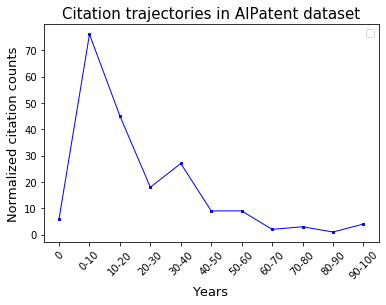

In [168]:
plt.plot(x1, y1, "bs-", linewidth = 1, markersize = 2)
plt.title("Citation trajectories in AIPatent dataset", fontsize=15)
plt.xlabel("Years",fontsize=13)
plt.ylabel("Normalized citation counts",fontsize=13)
plt.xticks(rotation=45)
plt.legend(loc = 0)
plt.show()

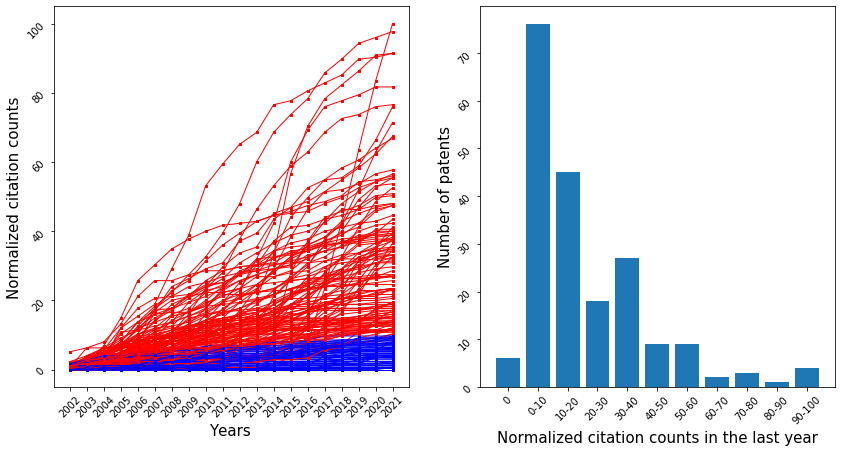

In [171]:
fig, axs = plt.subplots(1, 2, figsize=(14, 7))

for item in x:
    if item[-1] > np.mean(x):
        axs[0].plot(years, item, "rs-", linewidth = 1, markersize = 2)
    else:
        axs[0].plot(years, item, "bs-", linewidth = 1, markersize = 2)

axs[1].bar(x1, y1)


# fig.suptitle("Citation trajectories in AIPatent dataset", fontsize=15)
axs[0].set_xlabel("Years",fontsize=15)
axs[0].set_ylabel("Normalized citation counts",fontsize=15)
axs[1].set_xlabel("Normalized citation counts in the last year",fontsize=15)
axs[1].set_ylabel("Number of patents",fontsize=15)
axs[0].tick_params(labelrotation=45)
axs[1].tick_params(labelrotation=45)
plt.savefig('/Users/zongchang/downloads/dataset.pdf')
plt.show()

### AIPatent 新生专利和老专利样本生成

In [255]:
import pickle
patent_dataset_path = '/Users/zongchang/OneDrive/可泛化知识计算引擎/experiments/data/AIPatent'
with open(patent_dataset_path+'/temporal_graph_2012', 'rb') as f:
    graph_2012 = pickle.load(f)

In [256]:
with open(patent_dataset_path+'/temporal_graph_2011', 'rb') as f:
    graph_2011 = pickle.load(f)

In [257]:
name_2012 = list(graph_2012['name_idx'].keys())
name_2011 = list(graph_2011['name_idx'].keys())
newborn_2012 = []
old_2012 = []
for item in name_2012[:181436]:
    if item not in graph_2011['name_idx']:
        newborn_2012.append(item)
for item in name_2012[:181436]:
    if item in graph_2011['name_idx']:
        old_2012.append(item)

In [258]:
len(newborn_2012)

27101

In [259]:
len(old_2012)

154335

In [260]:
with open(patent_dataset_path+'/citation_label_10_2012', 'rb') as f:
    label = pickle.load(f)

In [261]:
len(label.keys())

103333

In [264]:
newborn_zero_cite = []
for item in newborn_2012:
    if item in label and label[item][0]['2012'] < 2:
        newborn_zero_cite.append(item)

In [270]:
old_grown_cite = []
for item in old_2012:
    if item in label and label[item][0]['2012'] > 12:
        old_grown_cite.append(item)

In [274]:
len(newborn_zero_cite)

9070

In [275]:
with open(patent_dataset_path+'/sample_names_2012_newborn', 'a') as f:
    for name in newborn_zero_cite:
          f.write(name + '\n')

In [276]:
len(old_grown_cite)

9081

In [277]:
with open(patent_dataset_path+'/sample_names_2012_grown', 'a') as f:
    for name in old_grown_cite:
          f.write(name + '\n')

### APS 新生专利和老专利样本生成

In [280]:
import pickle
patent_dataset_path = '/Users/zongchang/OneDrive/可泛化知识计算引擎/experiments/data/APS'
with open(patent_dataset_path+'/temporal_graph_2000', 'rb') as f:
    graph_2000 = pickle.load(f)

In [281]:
with open(patent_dataset_path+'/temporal_graph_1999', 'rb') as f:
    graph_1999 = pickle.load(f)

In [282]:
name_2000 = list(graph_2000['name_idx'].keys())
name_1999 = list(graph_1999['name_idx'].keys())


In [283]:
tmp_dict = {}
edges = list(graph_2000['adj']['citedBy'].edges())
for item in edges:
    if item[0] not in tmp_dict:
        tmp_dict[item[0]] = 0
    if item[1] not in tmp_dict:
        tmp_dict[item[1]] = 0

In [284]:
idx_list = list(tmp_dict.keys())
name_list = [graph_2000['idx_name'][item] for item in idx_list]

In [285]:
newborn_2000 = []
old_2000 = []
for item in name_list:
    if str(item) not in graph_1999['name_idx']:
        newborn_2000.append(str(item))
for item in name_list:
    if str(item) in graph_1999['name_idx']:
        old_2000.append(str(item))

In [286]:
newborn_2000

['3132545',
 '3149673',
 '3132588',
 '3132708',
 '3132898',
 '3149671',
 '3149541',
 '3132396',
 '3149818',
 '3132915',
 '3132490',
 '3132817',
 '3149784',
 '3132428',
 '3132874',
 '3132890',
 '3149283',
 '3149476',
 '3132517',
 '3149618',
 '3132270',
 '3132423',
 '3149817',
 '3132808',
 '3132902',
 '3132945',
 '3132604',
 '3198060',
 '3149593',
 '3255890',
 '3149286',
 '3149895',
 '3132705',
 '3218410',
 '3149863',
 '3263172',
 '3149489',
 '3359345',
 '3132802',
 '3149686',
 '3436465',
 '3132422',
 '3132953',
 '3149766',
 '3359336',
 '3132390',
 '3132682',
 '3359360',
 '3132397',
 '3132947',
 '3359328',
 '3359501',
 '3149738',
 '3132398',
 '3471647',
 '3390861',
 '3132515',
 '3132664',
 '3132380',
 '3149886',
 '3359953',
 '3132864',
 '3149327',
 '3149615',
 '3132355',
 '3132366',
 '3132669',
 '3132680',
 '3132377',
 '3149600',
 '3359577',
 '3132498',
 '3149771',
 '3149942',
 '3132949',
 '3359964',
 '3149406',
 '3149537',
 '3149866',
 '3132348',
 '3132461',
 '3132684',
 '3132859',
 '31

In [287]:
len(old_2000)

158504

In [288]:
with open(patent_dataset_path+'/citation_label_5_2000', 'rb') as f:
    label = pickle.load(f)

In [295]:
newborn_zero_cite = []
for item in newborn_2000:
    if item in label and label[item][0]['2000'] < 8:
        newborn_zero_cite.append(item)

In [296]:
len(newborn_zero_cite)

9079

In [305]:
old_grown_cite = []
for item in old_2000:
    if item in label and label[item][0]['2000'] > 28:
        old_grown_cite.append(item)

In [306]:
len(old_grown_cite)

9465

In [309]:
with open(patent_dataset_path+'/sample_names_2000_newborn', 'a') as f:
    for name in newborn_zero_cite:
          f.write(name + '\n')

In [310]:
with open(patent_dataset_path+'/sample_names_2000_grown', 'a') as f:
    for name in old_grown_cite:
          f.write(name + '\n')

## 节点在历年的id列表

In [57]:
year = 2012
step = 7
patent_dataset_path = '/Users/zongchang/OneDrive/可泛化知识计算引擎/experiments/data/AIPatent'
alignment_list = []
history_dict = []
for i in range(step):
    with open(patent_dataset_path+'/temporal_graph_'+str(year-step+i), 'rb') as f:
        tmp = pickle.load(f)
        history_dict.append(tmp['name_idx'])
with open(patent_dataset_path+'/temporal_graph_'+str(year), 'rb') as f:
    tmp = pickle.load(f)
    for idx in sorted(tmp['idx_name'].keys()):
        name = tmp['idx_name'][idx]
        history_idx = []
        for i in range(step):
            if name in history_dict[i]:
                history_idx.append(history_dict[i][name])
            else:
                history_idx.append(-1)
        alignment_list.append(history_idx)
        

In [58]:
with open(patent_dataset_path+'/alignment_list_2012_'+str(step), 'wb') as f:
    pickle.dump(alignment_list, f)

## CPC体系处理

In [36]:
import re
cpc_list = []
cpc_schema = {'cpc_code':'', 'cpc_desc':'', 'cpc_desc_full':''}
current_code = ''
with open('E:\\dataset\\全球AI专利数据\\cpc.nt', 'r', encoding='utf-8') as f:
    for line in f.readlines():
        tmp = re.split('^<http://data.epo.org/linked-data/def/cpc/', line)
        if len(tmp) > 1:
            if current_code != tmp[1].split('>')[0]:
                current_code = tmp[1].split('>')[0]
                cpc_list.append(cpc_schema)
                cpc_schema = {'cpc_code':'', 'cpc_desc':'', 'cpc_desc_full':''}
                cpc_schema['cpc_code'] = current_code.replace('-', '/')
                if 'http://purl.org/dc/terms/title' in line:
                    cpc_desc = line.split('"')[1].split('"')[0]
                    cpc_desc = cpc_desc.replace('{', '')
                    cpc_desc = cpc_desc.replace('}', '')
                    cpc_schema['cpc_desc'] = cpc_desc
                if 'http://data.epo.org/linked-data/def/cpc/fullTitle' in line:
                    cpc_desc_full = line.split('"')[1].split('"')[0]
                    cpc_desc_full = cpc_desc_full.replace('{', '')
                    cpc_desc_full = cpc_desc_full.replace('}', '')
                    cpc_schema['cpc_desc_full'] = cpc_desc_full
            else:
                if 'http://purl.org/dc/terms/title' in line:
                    cpc_desc = line.split('"')[1].split('"')[0]
                    cpc_desc = cpc_desc.replace('{', '')
                    cpc_desc = cpc_desc.replace('}', '')
                    cpc_schema['cpc_desc'] = cpc_desc
                if 'http://data.epo.org/linked-data/def/cpc/fullTitle' in line:
                    cpc_desc_full = line.split('"')[1].split('"')[0]
                    cpc_desc_full = cpc_desc_full.replace('{', '')
                    cpc_desc_full = cpc_desc_full.replace('}', '')
                    cpc_schema['cpc_desc_full'] = cpc_desc_full

In [37]:
cpc_dict = {}
for item in cpc_list:
    if item['cpc_code']:
        cpc_dict[item['cpc_code']] = item['cpc_desc']

In [38]:
cpc_dict['G06K9/0002']

'Image acquisition  by non-optical methods, e.g. by ultrasonic or capacitive sensing'

## 按维度分析专利情况

In [45]:
def count_by_cpc(year):
    with open(patent_data_path+'\\'+str(year)+'_patent_graph', 'rb') as f:
        res = pickle.load(f)

    cpc_count = {}
    for item in res['relatedTo']:
        if item[1] not in cpc_count:
            cpc_count[item[1]] = 0
        else:
            cpc_count[item[1]] += 1

    cpc_count = sorted(cpc_count.items(), key = lambda kv:(kv[1], kv[0]), reverse=True)
    return cpc_count

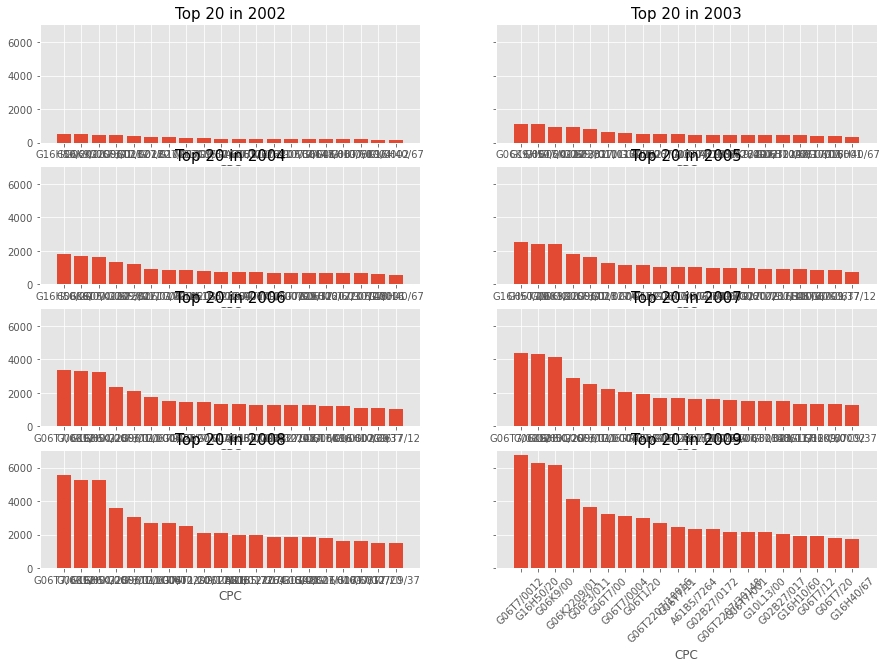

In [69]:
import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use("ggplot")
fig, axes = plt.subplots(4,2,figsize=(15, 10), sharey=True)
axes = axes.flatten()
years = [2002,2003,2004,2005,2006,2007,2008,2009]
for i in range(8):
    cpc_count = count_by_cpc(years[i])
    X = []
    Y = []
    topK = 20
    for j in range(topK):
        X.append(cpc_count[j][0])
        Y.append(cpc_count[j][1])
    
    axes[i].bar(x=X, height=Y)
    axes[i].set_title("Top "+str(topK)+" in "+str(years[i]), fontsize=15)
    axes[i].set_xlabel("CPC")
plt.xticks(rotation=45)
plt.show()

## 专利引证网络统计分析

In [1]:
import networkx as nx
import pickle

G = nx.Graph()

In [2]:
year = '2021'
patent_data_path = 'E:\\dataset\\全球AI专利数据\\'
with open(patent_data_path+'\\'+year+'_patent_graph', 'rb') as f:
    patent_graph = pickle.load(f)
    all_patent = {}
#    all_cpc = {}
    for item in patent_graph['citedBy']:
        if item[0] not in all_patent:
            all_patent[item[0]] = 0
        if item[1] not in all_patent:
            all_patent[item[1]] = 0
#        if item[1] not in all_cpc:
#            all_cpc[item[1]] = 0
    patents = list(all_patent.keys())
#    cpcs = list(all_cpc.keys())
    G.add_nodes_from(patents)
#    G.add_nodes_from(cpcs)

In [2]:
year = '2021'
patent_data_path = 'E:\\dataset\\全球AI专利数据\\'
with open(patent_data_path+'\\'+year+'_patent_graph', 'rb') as f:
    patent_graph = pickle.load(f)
    all_cpc = {}
    for item in patent_graph['relatedTo']:
        if item[1] not in all_cpc:
            all_cpc[item[1]] = 0
    cpcs = list(all_cpc.keys())
    G.add_nodes_from(cpcs)

In [3]:
len(list(all_cpc.keys()))

67146

In [4]:
len(list(all_patent.keys()))

606722

In [4]:
len(patent_graph['relatedTo'])

11191407

In [5]:
len(patent_graph['citedBy'])

2371701

In [59]:
# edges = patent_graph['relatedTo']
# edges.extend(patent_graph['citedBy'])
edges = patent_graph['citedBy']
G.add_edges_from(edges)

In [60]:
G.degree['US6335977B1']

67

In [61]:
len(G.edges())

2368968

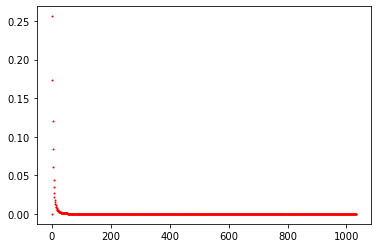

In [65]:
import matplotlib.pyplot as plt

degree = nx.degree_histogram(G)
x = range(len(degree))
y = [z/float(sum(degree)) for z in degree]
plt.scatter(x, y, s=1, color=(1,0,0))
plt.show()

In [68]:
degrees = [d for n, d in G.degree()]
sum(degrees) / len(degrees)

7.809072359334259

NameError: name 'a' is not defined

## 模型性能指标曲线

In [13]:
import numpy as np
import matplotlib.pyplot as plt

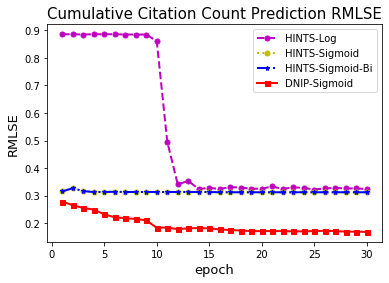

In [27]:
epoch = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30]
hints_log = [0.886,0.886,0.885,0.886,0.886,0.886,0.885,0.885,0.885,0.861,0.496,0.341,0.353,0.324,0.328,0.324,0.331,0.329,0.325,0.325,0.333,0.324,0.330,0.328,0.322,0.326,0.328,0.326,0.326,0.324]
hints_sig = [0.315,0.327,0.316,0.313,0.313,0.314,0.313,0.313,0.313,0.313,0.313,0.313,0.313,0.313,0.313,0.312,0.312,0.312,0.312,0.312,0.312,0.312,0.312,0.312,0.312,0.312,0.312,0.312,0.312,0.312]
hints_sig_bi=[0.371,0.315,0.315,0.314,0.313,0.313,0.313,0.312,0.313,0.313,0.313,0.313,0.313,0.313,0.313,0.313,0.313,0.313,0.313,0.313,0.313,0.313,0.313,0.313,0.313,0.313,0.313,0.313,0.313,0.313]

dnip_sig=[0.278,0.265,0.255,0.249,0.232,0.221,0.218,0.215,0.210,0.183,0.184,0.178,0.181,0.182,0.181,0.177,0.175,0.173,0.171,0.171,0.171,0.171,0.170,0.170,0.171,0.172,0.171,0.169,0.169,0.168]

plt.plot(epoch, hints_log, "mo--", linewidth = 2, markersize = 5, label = "HINTS-Log")

plt.plot(epoch, hints_sig, "yo:", linewidth = 2, markersize = 5, label = "HINTS-Sigmoid")

plt.plot(epoch, hints_sig, "b*-.", linewidth = 2, markersize = 5, label = "HINTS-Sigmoid-Bi")

plt.plot(epoch, dnip_sig, "rs-", linewidth = 2, markersize = 5, label = "DNIP-Sigmoid")

plt.title("Cumulative Citation Count Prediction RMLSE", fontsize=15)
plt.xlabel("epoch",fontsize=13)
plt.ylabel("RMLSE",fontsize=13)
plt.legend(loc = 0)
plt.show()

## 被引用量曲线分析

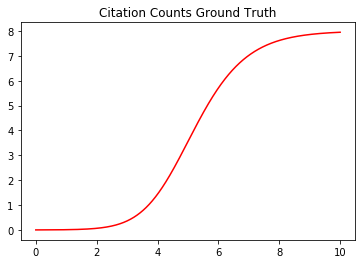

In [3]:
import numpy as np

import matplotlib.pyplot as plt

a = np.linspace(0, 10, 1000)

b = 8.0 / np.power((1.0 + 0.5*np.exp(-(a-5))), 1/0.5)

plt.title('Citation Counts Ground Truth')

plt.plot(a, b, color='red')

plt.show()

In [22]:
import pickle
patent_dataset_path = '/Users/zongchang/OneDrive/可泛化知识计算引擎/experiments/data/APS'
with open(patent_dataset_path+'/citation_label_5_2000', 'rb') as f:
    res = pickle.load(f)

In [25]:
new_outcomes = {}
for k,v in res.items():
    if v[0]['2000'] == 0:
        new_outcomes[k] = v
    else:
        continue

In [26]:
new_outcomes

{'3145751': [{'2000': 0}, {'2001': 1}, {'2002': 1}, {'2003': 1}, {'2004': 1}],
 '3149420': [{'2000': 0}, {'2001': 1}, {'2002': 2}, {'2003': 2}, {'2004': 2}],
 '3149885': [{'2000': 0}, {'2001': 0}, {'2002': 0}, {'2003': 1}, {'2004': 1}],
 '3149963': [{'2000': 0}, {'2001': 0}, {'2002': 1}, {'2003': 1}, {'2004': 1}],
 '3155120': [{'2000': 0}, {'2001': 0}, {'2002': 0}, {'2003': 0}, {'2004': 1}],
 '3001569': [{'2000': 0}, {'2001': 1}, {'2002': 1}, {'2003': 1}, {'2004': 1}],
 '3165420': [{'2000': 0}, {'2001': 0}, {'2002': 1}, {'2003': 1}, {'2004': 1}],
 '3170230': [{'2000': 0}, {'2001': 1}, {'2002': 1}, {'2003': 1}, {'2004': 1}],
 '3170488': [{'2000': 0}, {'2001': 1}, {'2002': 3}, {'2003': 3}, {'2004': 3}],
 '3132701': [{'2000': 0}, {'2001': 0}, {'2002': 0}, {'2003': 1}, {'2004': 1}],
 '3132753': [{'2000': 0}, {'2001': 0}, {'2002': 0}, {'2003': 1}, {'2004': 1}],
 '3186441': [{'2000': 0}, {'2001': 1}, {'2002': 2}, {'2003': 2}, {'2004': 2}],
 '3186520': [{'2000': 0}, {'2001': 0}, {'2002': 0}, 

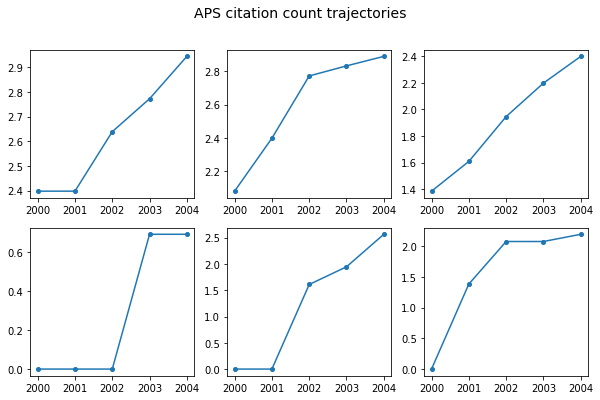

In [40]:
import math
import matplotlib.pyplot as plt

a = ['2000','2001','2002','2003','2004']

b = [[11,11,14,16,19],[8,11,16,17,18],[4,5,7,9,11],[0, 1,1,2,2], [0, 1, 5, 7, 13], [0, 4, 8, 8, 9],[0, 2, 7, 10, 13]]

c = []
for item in b:
    tmp = []
    for x in item:
        if x > 0:
            tmp.append(math.log(x))
        else:
            tmp.append(0)
    c.append(tmp)

fig, axs = plt.subplots(2, 3, figsize=(10, 6))
fig.suptitle('APS citation count trajectories', fontsize=14)
for ax, y in zip(axs.flat, c):
    ax.plot(a, y, 'o', ls='-', ms=4)
plt.show()

In [39]:
c

[[2.3978952727983707,
  2.3978952727983707,
  2.6390573296152584,
  2.772588722239781,
  2.9444389791664403],
 [2.0794415416798357,
  2.3978952727983707,
  2.772588722239781,
  2.833213344056216,
  2.8903717578961645],
 [1.3862943611198906,
  1.6094379124341003,
  1.9459101490553132,
  2.1972245773362196,
  2.3978952727983707],
 [0, 0.0, 0.0, 0.6931471805599453, 0.6931471805599453],
 [0, 0.0, 1.6094379124341003, 1.9459101490553132, 2.5649493574615367],
 [0,
  1.3862943611198906,
  2.0794415416798357,
  2.0794415416798357,
  2.1972245773362196],
 [0,
  0.6931471805599453,
  1.9459101490553132,
  2.302585092994046,
  2.5649493574615367]]

In [27]:
import pickle
patent_dataset_path = '/Users/zongchang/OneDrive/可泛化知识计算引擎/experiments/data/AIPatent'
with open(patent_dataset_path+'/citation_label_10_2012', 'rb') as f:
    res = pickle.load(f)

In [28]:
new_outcomes = {}
for k,v in res.items():
    if v[0]['2012'] >= 0:
        new_outcomes[k] = v
    else:
        continue

In [29]:
new_outcomes

{'US20120086550A1': [{'2012': 10},
  {'2013': 10},
  {'2014': 10},
  {'2015': 10},
  {'2016': 12},
  {'2017': 13},
  {'2018': 15},
  {'2019': 17},
  {'2020': 19},
  {'2021': 21}],
 'US20120191016A1': [{'2012': 2},
  {'2013': 2},
  {'2014': 3},
  {'2015': 3},
  {'2016': 4},
  {'2017': 5},
  {'2018': 6},
  {'2019': 10},
  {'2020': 14},
  {'2021': 14}],
 'US20120148118A1': [{'2012': 20},
  {'2013': 24},
  {'2014': 29},
  {'2015': 31},
  {'2016': 33},
  {'2017': 35},
  {'2018': 36},
  {'2019': 40},
  {'2020': 41},
  {'2021': 42}],
 'US20120086659A1': [{'2012': 1},
  {'2013': 3},
  {'2014': 3},
  {'2015': 4},
  {'2016': 6},
  {'2017': 8},
  {'2018': 9},
  {'2019': 9},
  {'2020': 9},
  {'2021': 9}],
 'US20120274598A1': [{'2012': 5},
  {'2013': 5},
  {'2014': 5},
  {'2015': 5},
  {'2016': 5},
  {'2017': 6},
  {'2018': 7},
  {'2019': 8},
  {'2020': 8},
  {'2021': 9}],
 'US20120086727A1': [{'2012': 7},
  {'2013': 13},
  {'2014': 18},
  {'2015': 22},
  {'2016': 25},
  {'2017': 39},
  {'2018': 50

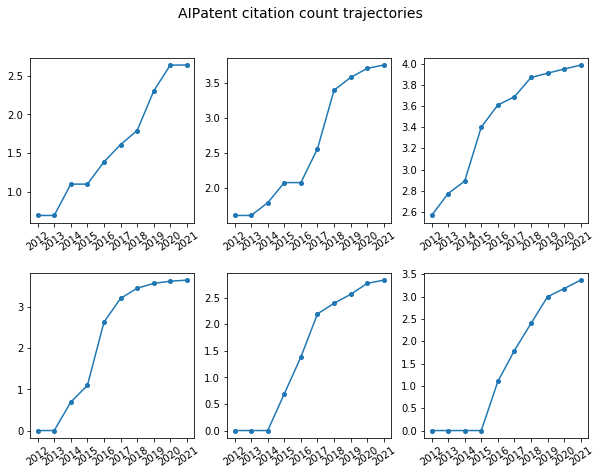

In [33]:
import math
import matplotlib.pyplot as plt

a = ['2012','2013','2014','2015','2016','2017','2018','2019','2020','2021']

b = [[2,2,3,3,4,5,6,10,14,14], [5,5,6,8,8,13,30,36,41,43], [13,16,18,30,37,40,48,50,52,54], [0,1,2,3,14,25,32,36,38,39],[0,0,0,2,4,9,11,13,16,17], [0,0,0,1,3,6,11,20,24,29]]
c = []
for item in b:
    tmp = []
    for x in item:
        if x > 0:
            tmp.append(math.log(x))
        else:
            tmp.append(0)
    c.append(tmp)

fig, axs = plt.subplots(2, 3, figsize=(10, 7))
plt.subplots_adjust(wspace=0.2,hspace=0.3)
fig.suptitle('AIPatent citation count trajectories', fontsize=14)
for ax, y in zip(axs.flat, c):
    ax.plot(a, y, 'o', ls='-', ms=4)
    ax.set_xticklabels(labels=a, rotation=35)
plt.show()

In [34]:
c

[[0.6931471805599453,
  0.6931471805599453,
  1.0986122886681098,
  1.0986122886681098,
  1.3862943611198906,
  1.6094379124341003,
  1.791759469228055,
  2.302585092994046,
  2.6390573296152584,
  2.6390573296152584],
 [1.6094379124341003,
  1.6094379124341003,
  1.791759469228055,
  2.0794415416798357,
  2.0794415416798357,
  2.5649493574615367,
  3.4011973816621555,
  3.58351893845611,
  3.713572066704308,
  3.7612001156935624],
 [2.5649493574615367,
  2.772588722239781,
  2.8903717578961645,
  3.4011973816621555,
  3.6109179126442243,
  3.6888794541139363,
  3.871201010907891,
  3.912023005428146,
  3.9512437185814275,
  3.9889840465642745],
 [0,
  0.0,
  0.6931471805599453,
  1.0986122886681098,
  2.6390573296152584,
  3.2188758248682006,
  3.4657359027997265,
  3.58351893845611,
  3.6375861597263857,
  3.6635616461296463],
 [0,
  0,
  0,
  0.6931471805599453,
  1.3862943611198906,
  2.1972245773362196,
  2.3978952727983707,
  2.5649493574615367,
  2.772588722239781,
  2.833213344

In [ ]:
# APS TGNN RMLSE
mix: 0.9585
newborn: 0.6183
grown: 0.5588
# APS HINTS RMLSE
mix: 0.9593
newborn: 0.6292
grown: 0.4455
# APS HINTS with Logistic RMLSE
mix: 0.9562
newborn: 0.6285
grown: 0.4352
# APS CTPIR with GCN RMLSE
mix: 0.2065
newborn: 0.2798
grown: 0.1639
# APS CTPIR RMLSE
mix: 0.1982
newborn: 0.2774
grown: 0.1628
    
# APS TGNN MALE
mix: 0.8153
newborn: 0.5443
grown: 0.3269
# APS HINTS MALE
mix: 0.8219
newborn: 0.6570
grown: 0.3054
# APS HINTS with Logistic MALE
mix: 0.8168
newborn: 0.5423
grown: 0.3050
# APS CTPIR with GCN MALE
mix: 0.1268
newborn: 0.1815
grown: 0.1183
# APS CTPIR MALE
mix: 0.1247
newborn: 0.1804
grown: 0.0938
    
# AIPatent TGNN RMLSE
mix: 1.0114
newborn: 0.6452
grown: 0.6433
# AIPatent HINTS RMLSE
mix: 1.0272
newborn: 0.6596
grown: 0.6197
# AIPatent HINTS with Logistic RMLSE
mix: 1.0243
newborn:0.6522
grown: 0.6005
# AIPatent CTPIR with GCN RMLSE
mix: 0.5542
newborn: 0.6465
grown: 0.3896
# AIPatent CTPIR RMLSE
mix: 0.5129
newborn: 0.6457
grown: 0.3646
    
# AIPatent TGNN MALE
mix: 0.8169
newborn: 0.4698
grown: 0.5403
# AIPatent HINTS MALE
mix: 0.8285
newborn: 0.4971
grown: 0.5298
# AIPatent HINTS with Logistic MALE
mix: 0.8233
newborn: 0.4890
grown: 0.4904
# AIPatent CTPIR with GCN MALE
mix: 0.3794
newborn: 0.4682
grown: 0.2802
# AIPatent CTPIR MALE
mix: 0.3545
newborn: 0.4597
grown: 0.2619

In [ ]:
# APS CTPIR RMLSE
all year: 0.1982
5 year: 0.2555
4 year: 0.2395
3 year: 0.1794
2 year: 0.1199
1 year: 0.0134
# APS CTPIR-Influence RMLSE
all year: 0.9500
# APS CTPIR-Diff RMLSE
all year: 0.2065
# APS CTPIR-Logistic RMLSE
all year: 0.2319
    
# APS CTPIR MALE
all year: 0.1247
5 year: 0.1915
4 year: 0.1506
3 year: 0.1216
2 year: 0.1007
1 year: 0.0470
# APS CTPIR-Influence MALE
all year: 0.8104
# APS CTPIR-Diff MALE
all year: 0.1268
# APS CTPIR-Logistic MALE
all year: 0.1664

In [ ]:
# AIPatent CTPIR RMLSE
all year: 0.5129
10 year: 0.6709
9 year: 0.6488
8 year: 0.6189
7 year: 0.5821
6 year: 0.5326
5 year: 0.4729
4 year: 0.3969
3 year: 0.3050
2 year: 0.1879
1 year: 0.0253
# AIPatent CTPIR-Influence RMLSE
all year: 1.0175
# AIPatent CTPIR-Diff RMLSE
all year: 0.5442
# AIPatent CTPIR-Logistic RMLSE
all year: 0.5693
    
# AIPatent CTPIR MALE
all year: 0.3545
10 year: 0.5118
9 year: 0.4975
8 year: 0.4643
7 year: 0.4302
6 year: 0.3871
5 year: 0.3379
4 year: 0.2880
3 year: 0.1925
2 year: 0.1141
1 year: 0.0321
# AIPatent CTPIR-Influence MALE
all year: 0.8148
# AIPatent CTPIR-Diff MALE
all year: 0.3794
# AIPatent CTPIR-Logistic MALE
all year: 0.4001

## Process predicted results for visualization evaluation

In [47]:
import json
output_seq = []
predict_seq_ctpir = []
predict_seq_hints = []
predict_seq_tgnn = []
with open('./output_seq', 'r') as f:
    lines = f.readlines()
    for line in lines:
        output_seq.append(json.loads(line.strip()))
with open('./predict_seq_ctpir', 'r') as f:
    lines = f.readlines()
    for line in lines:
        predict_seq_ctpir.append(json.loads(line.strip()))
with open('./predict_seq_hints', 'r') as f:
    lines = f.readlines()
    for line in lines:
        predict_seq_hints.append(json.loads(line.strip()))
with open('./predict_seq_tgnn', 'r') as f:
    lines = f.readlines()
    for line in lines:
        predict_seq_tgnn.append(json.loads(line.strip()))

In [48]:
import numpy as np
import json

output_seq = np.array(output_seq[:100])
predict_seq_ctpir = np.array(predict_seq_ctpir[:100])
predict_seq_hints = np.array(predict_seq_hints[:100])
predict_seq_tgnn = np.array(predict_seq_tgnn[:100])

In [49]:
max_cite = output_seq.max()
min_cite = output_seq.min()
max_cite_ctpir = predict_seq_ctpir.max()
min_cite_ctpir = predict_seq_ctpir.min()
max_cite_hints = predict_seq_hints.max()
min_cite_hints = predict_seq_hints.min()
max_cite_tgnn = predict_seq_tgnn.max()
min_cite_tgnn = predict_seq_tgnn.min()

In [50]:
scale_hints =  (max_cite - min_cite) / (max_cite_hints - min_cite_hints)
scale_ctpir =  (max_cite - min_cite) / (max_cite_ctpir - min_cite_ctpir)
scale_tgnn = (max_cite - min_cite) / (max_cite_tgnn - min_cite_tgnn)
predict_seq_hints_scaled = (predict_seq_hints - min_cite_hints) * scale_hints +min_cite
predict_seq_ctpir_scaled = (predict_seq_ctpir - min_cite_ctpir) * scale_ctpir +min_cite
predict_seq_tgnn_scaled = (predict_seq_tgnn - min_cite_tgnn) * scale_tgnn +min_cite

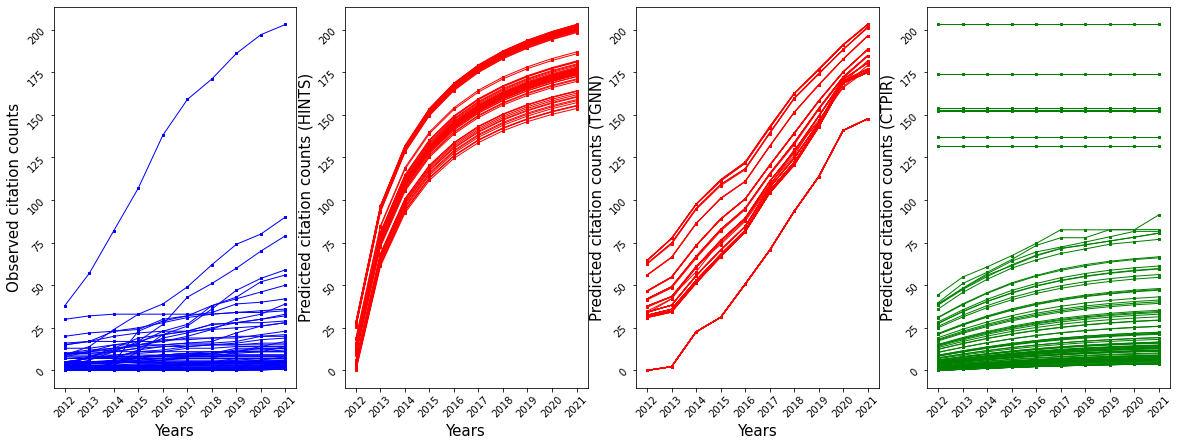

In [51]:
import matplotlib.pyplot as plt

years = ['2012','2013','2014','2015','2016','2017','2018','2019','2020','2021']
item_ob = output_seq.tolist()[:100]
item_hints = predict_seq_hints_scaled.tolist()
item_tgnn = predict_seq_tgnn_scaled.tolist()
item_ctpir = predict_seq_ctpir_scaled.tolist()

fig, axs = plt.subplots(1, 4, figsize=(20, 7))

for item in item_ob:
    axs[0].plot(years, item, "bs-", linewidth = 1, markersize = 2)

for item in item_hints:
    axs[1].plot(years, item, "rs-", linewidth = 1, markersize = 2)

for item in item_tgnn:
    axs[2].plot(years, item, "rs-", linewidth = 1, markersize = 2)
    
for item in item_ctpir:
    axs[3].plot(years, item, "gs-", linewidth = 1, markersize = 2)


# fig.suptitle("Citation trajectories in AIPatent dataset", fontsize=15)
axs[0].set_xlabel("Years",fontsize=15)
axs[0].set_ylabel("Observed citation counts",fontsize=15)
axs[1].set_xlabel("Years",fontsize=15)
axs[1].set_ylabel("Predicted citation counts (HINTS)",fontsize=15)
axs[2].set_xlabel("Years",fontsize=15)
axs[2].set_ylabel("Predicted citation counts (TGNN)",fontsize=15)
axs[2].set_xlabel("Years",fontsize=15)
axs[3].set_ylabel("Predicted citation counts (CTPIR)",fontsize=15)
axs[0].tick_params(labelrotation=45)
axs[1].tick_params(labelrotation=45)
axs[2].tick_params(labelrotation=45)
axs[3].tick_params(labelrotation=45)
plt.savefig('./result_compare.png')
plt.show()